In [1]:
!pip install  pyDOE

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/


In [2]:
#5.new1_normal
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from torch.autograd import grad
from pyDOE import lhs
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys 
import matplotlib.ticker as ticker


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype=torch.float32
torch.set_default_dtype(dtype)



def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
        #torch.backends.cudnn.deterministic = True
        #torch.backends.cudnn.benchmark = False


seed = 8888
setup_seed(seed)



class layer(nn.Module):
    def __init__(self, n_in, n_out, activation):
        super().__init__()
        self.layer = nn.Linear(n_in, n_out)
        self.activation = activation

    def forward(self, x):
        x = self.layer(x)
        if self.activation:
            x = self.activation(x)
        return x


class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, n_layer, n_node, ub, lb, activation=nn.Tanh()):
        super().__init__()
        self.net = nn.ModuleList()
        self.net.append(layer(dim_in, n_node, activation))
        for _ in range(n_layer):
            self.net.append(layer(n_node, n_node, activation))
        self.net.append(layer(n_node, dim_out, activation=None))
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        self.net.apply(weights_init)  # xavier initialization

    def forward(self, x):
        out = x
        for layer in self.net:
            out = layer(out)
        return out



def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

def rhs(x):
    
    return -6*(x[:,0:1]**3)*x[:,1:2]+x[:,1:2]*(6*x[:,0:1]*x[:,1:2]**2-25*(np.pi**2)*torch.cos(5*np.pi*x[:,0:1]))+((x[:,0:1]*x[:,1:2])**3+x[:,1:2]*torch.cos(5*np.pi*x[:,0:1]))**3

    


def u(t,x):
    Z = x*np.cos(5*np.pi*t)+(x*t)**3
    return Z


# Parameters
t_min = 0
t_max = 1
x_min = 0
x_max = 1


ub = np.array([t_max, x_max])
lb = np.array([t_min, x_min])


N_bc = 500
N_f = 5000


########


t_points = lambda n: np.random.uniform(t_min, t_max, (n, 1))
x_points = lambda n: np.random.uniform(x_min, x_max, (n, 1))





# collocation points


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net = DNN(dim_in=2, dim_out=1, n_layer=5, n_node=50, ub=ub, lb=lb).to(device)
        self.iter = 0
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(),
            lr=1,
            max_iter=20000,
            max_eval=20000,
            history_size=200,
            tolerance_grad=1e-12, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )#tolerance_change=1.0 * np.finfo(float).eps,
        self.adam = torch.optim.Adam(self.net.parameters(), lr=2e-3)
        self.scheduler=torch.optim.lr_scheduler.StepLR(self.adam,step_size=30,gamma=0.99)
        self.losses = {"loss": [], "bc": [], "pde": []}

    
    def loss_bc(self, xyt,u_t):
        u = self.net(xyt)
        mse_ic = torch.mean(torch.square(u - u_t))
        return mse_ic
    
    def loss_bc1(self, xyt):
        xy = xyt.clone()
        xy.requires_grad = True
        
        u = self.net(xy)
        u_t = grad(u, xy, grad_outputs=torch.ones_like(u),create_graph=True)[0][:, 0:1]
        
        mse_ic = torch.mean(torch.square(u_t))
        return mse_ic

    def loss_pde(self, xyt):
        xy = xyt.clone()
        xy.requires_grad = True
        
        u = self.net(xy)
        

        u_xyt = grad(u, xy, grad_outputs=torch.ones_like(u),create_graph=True)[0]
        u_xx = grad(u_xyt[:, 1:2].sum(), xy,create_graph=True)[0][:, 1:2]
        u_tt = grad(u_xyt[:, 0:1].sum(), xy,create_graph=True)[0][:, 0:1]

        
        pde =-rhs(xy)+u_tt+u**3 - u_xx
        
        mse_pde = torch.mean(torch.square(pde))
        
        return mse_pde
    
    

    def closure(self):
        self.optimizer.zero_grad()
        self.adam.zero_grad()
        
        
        mse_bc = self.loss_bc(tx_bc,u_bc)
        mse_ic = self.loss_bc(tx_ic,u_ic)
        mse_bc1 = self.loss_bc1(tx_ic)
        mse_pde = self.loss_pde(tx_f)

        
        loss = mse_bc + mse_pde +mse_ic+mse_bc1
        
        loss.backward()
    
        self.losses["loss"]=loss.detach().cpu().item()
        self.losses["ic"]=mse_ic.detach().cpu().item()
        self.losses["bc"]=mse_bc.detach().cpu().item()
        self.losses["bc1"]=mse_bc1.detach().cpu().item()
        self.losses["pde"]=mse_pde.detach().cpu().item()
        
        
        if self.iter % 5000 == 0:

            print(f"{self.iter} Loss: {loss.item():.5e}  IC: {mse_ic.item():.5e} BC: {mse_bc.item():.5e} BC1: {mse_bc1.item():.5e} pde:{mse_pde.item():.5e}")
        self.iter += 1
        return loss


    
  
if __name__ == "__main__":

    pinn = PINN()
    
    
    
    
    t_bc1 = np.ones((N_bc, 1))*t_min
    x_bc1 = x_points(N_bc)
    
    

    t_bc3 = t_points(N_bc//2)
    x_bc3 = np.ones((N_bc//2, 1))*x_min

    
    t_bc4 = t_points(N_bc//2)
    x_bc4 = np.ones((N_bc//2, 1)) * x_max


    t_bc = np.vstack([t_bc3, t_bc4])
    x_bc = np.vstack([x_bc3, x_bc4])
    tx_bc = np.hstack([t_bc, x_bc])
    tx_ic = np.hstack([t_bc1,x_bc1])
    u_bc = u(t_bc,x_bc)
    u_ic = u(t_bc1,x_bc1)
    
    
    t_f = t_min + (t_max - t_min) * lhs(1, N_f)
    x_f = x_min + (x_max - x_min) * lhs(1, N_f)
    tx_f = np.hstack([t_f, x_f])
    tx_f = np.vstack([tx_f, tx_bc])


    
    
    
    
    tx_bc = torch.tensor(tx_bc, dtype=dtype).to(device)
    tx_ic = torch.tensor(tx_ic, dtype=dtype).to(device)
    u_ic = torch.tensor(u_ic, dtype=dtype).to(device)
    u_bc = torch.tensor(u_bc, dtype=dtype).to(device)
    tx_f = torch.tensor(tx_f, dtype=dtype).to(device)
    '''
    for i in range(5000):
        pinn.closure()
        pinn.adam.step()
        #pinn.Yogi.step()
        pinn.scheduler.step()
        #y.append(pinn.scheduler.get_last_lr()[0])
    pinn.optimizer.step(pinn.closure)
    #print_log = open(log_t,'a+')
    print(f"{pinn.iter} Loss: {pinn.losses['loss']:.5e}  IC: {pinn.losses['ic']:.5e} BC: {pinn.losses['bc']:.5e} BC1: {pinn.losses['bc1']:.5e} pde: {pinn.losses['pde']:.5e}")
    #print_log.close()
    '''
   

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
error_vec_inf_1 = []
error_vec_2_1 = []
for ttt in range(1):
    pinn = PINN()
    print("第",ttt,"次训练——————————————————————————————")
    
    t_bc1 = np.ones((N_bc, 1))*t_min
    x_bc1 = x_points(N_bc)
    #u_bc1 = np.zeros((N_bc, 1))
    

    t_bc3 = t_points(N_bc)
    x_bc3 = np.ones((N_bc, 1))*x_min
    #u_bc3 = np.zeros((N_bc, 1))
    
    t_bc4 = t_points(N_bc)
    x_bc4 = np.ones((N_bc, 1)) * x_max
    #u_bc4 = np.zeros((N_bc, 1))

    t_bc = np.vstack([t_bc3, t_bc4])
    x_bc = np.vstack([x_bc3, x_bc4])
    tx_bc = np.hstack([t_bc, x_bc])
    tx_ic = np.hstack([t_bc1,x_bc1])
    u_bc = u(t_bc,x_bc)
    u_ic = u(t_bc1,x_bc1)
    
    
    t_f = t_min + (t_max - t_min) * lhs(1, N_f)
    x_f = x_min + (x_max - x_min) * lhs(1, N_f)
    tx_f = np.hstack([t_f, x_f])
    tx_f = np.vstack([tx_f, tx_bc])
    
    
    
    tx_bc = torch.tensor(tx_bc, dtype=dtype).to(device)
    tx_ic = torch.tensor(tx_ic, dtype=dtype).to(device)
    u_ic = torch.tensor(u_ic, dtype=dtype).to(device)
    u_bc = torch.tensor(u_bc, dtype=dtype).to(device)
    tx_f = torch.tensor(tx_f, dtype=dtype).to(device)
    
    
    
    
    
    for k in range(5000):
        pinn.closure()
        pinn.adam.step()
        pinn.scheduler.step()
    pinn.optimizer.step(pinn.closure)
    print(f"{pinn.iter} Loss: {pinn.losses['loss']:.5e}  IC: {pinn.losses['ic']:.5e} BC: {pinn.losses['bc']:.5e} BC1: {pinn.losses['bc1']:.5e} pde: {pinn.losses['pde']:.5e}")
    T0,X0 = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
    Z0 = X0*np.cos(5*np.pi*T0)+(X0*T0)**3
    tX,tY = torch.tensor(T0,dtype=torch.float32,device=device),torch.tensor(X0,dtype=torch.float32,device=device)
    with torch.inference_mode(1):tZ = pinn.net(torch.cat([tX.reshape(-1,1),tY.reshape(-1,1)],dim=1)).reshape(101,101)
    U0 = tZ.cpu().numpy()
    err=torch.from_numpy(Z0-U0)
    u_norm=torch.from_numpy(U0)
    error_vec_inf_1.append(float( torch.linalg.vector_norm(err,float('inf')).numpy()))
    error_vec_2_1.append(float((torch.linalg.vector_norm(err,2)/torch.linalg.vector_norm(u_norm,2)).numpy()))
#torch.save(pinn.state_dict(), 'KG-normal.pt')

第 0 次训练——————————————————————————————
0 Loss: 1.09806e+04  IC: 3.04731e-01 BC: 2.91032e-01 BC1: 1.92044e-01 pde:1.09798e+04
5000 Loss: 6.19712e-01  IC: 3.22687e-02 BC: 2.11195e-01 BC1: 8.59656e-03 pde:3.67652e-01
10000 Loss: 1.56128e-03  IC: 6.11988e-05 BC: 7.39878e-04 BC1: 7.11859e-06 pde:7.53082e-04
11387 Loss: 7.98748e-04  IC: 2.41133e-05 BC: 2.26916e-04 BC1: 6.88734e-06 pde: 5.40832e-04


In [4]:
print("L_inf",error_vec_inf_1,"mean:",np.mean(error_vec_inf_1),"var:",np.std(error_vec_inf_1))
print("L_2",error_vec_2_1,"mean:",np.mean(error_vec_2_1),"var:",np.std(error_vec_2_1))

L_inf [0.08041368424892437] mean: 0.08041368424892437 var: 0.0
L_2 [0.027281938101718074] mean: 0.027281938101718074 var: 0.0


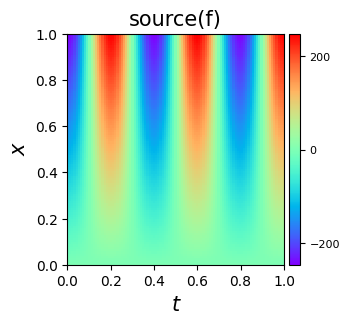

In [5]:
extent=[t_min, t_max, x_min, x_max]
T0,X0 = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
Z0 = -6*(T0**3)*X0+X0*(6*T0*X0**2-25*(np.pi**2)*np.cos(5*np.pi*T0))+((T0*X0)**3+X0*np.cos(5*np.pi*T0))**3
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
h = ax.imshow(Z0, interpolation='nearest', cmap='rainbow', 
              extent=extent, 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(2)  # colorbar上的刻度值个数
cbar.locator = tick_locator
ax.set_title('source(f)',fontsize=15)
ax.set_xlabel('t', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('x', fontsize=15,fontstyle='oblique')
plt.savefig('./pic/sour_1.pdf', format='pdf', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

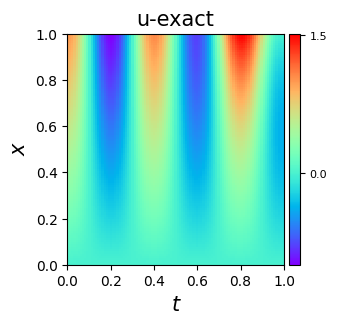

In [6]:
extent=[t_min, t_max, x_min, x_max]
T0,X0 = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
Z0 = X0*np.cos(5*np.pi*T0)+(X0*T0)**3

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
h = ax.imshow(Z0, interpolation='nearest', cmap='rainbow', 
              extent=extent, 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(2)#nbins=2)  # colorbar上的刻度值个数
cbar.locator = tick_locator
ax.set_title('u-exact',fontsize=15)
ax.set_xlabel('t', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('x', fontsize=15,fontstyle='oblique')
plt.savefig('./pic/6_real.pdf', format='pdf', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

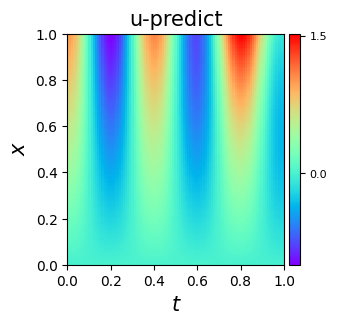

In [7]:

tX,tY = torch.tensor(T0,dtype=torch.float32,device=device),torch.tensor(X0,dtype=torch.float32,device=device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([tX.reshape(-1,1),tY.reshape(-1,1)],dim=1)).reshape(101,101)
U0 = tZ.cpu().numpy()
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
h = ax.imshow(U0, interpolation='nearest', cmap='rainbow', 
              extent=extent, 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(h, cax=cax)

cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(2)#nbins=2)  # colorbar上的刻度值个数
cbar.locator = tick_locator
#tick_locator = ticker.MaxNLocator(nbins=6)  # colorbar上的刻度值个数
#cbar.locator = tick_locator


ax.set_title('u-predict',fontsize=15)
ax.set_xlabel('t', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('x', fontsize=15,fontstyle='oblique')
plt.savefig('./pic/6_real.pdf', format='pdf', bbox_inches='tight')

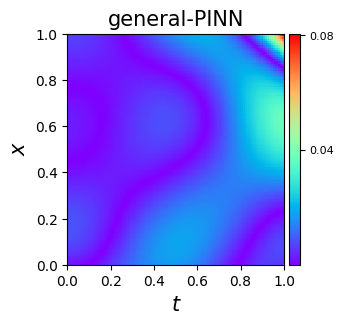

In [8]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
h = ax.imshow(abs(Z0-U0), interpolation='nearest', cmap='rainbow', 
              extent=extent, 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(h, cax=cax) 
cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(2)#nbins=2)  # colorbar上的刻度值个数
cbar.locator = tick_locator
#tick_locator = ticker.MaxNLocator(nbins=6)  # colorbar上的刻度值个数
#cbar.locator = tick_locator

ax.set_title('general-PINN',fontsize=15)
ax.set_xlabel('t', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('x', fontsize=15,fontstyle='oblique')
plt.savefig('./pic/6_err_normal.pdf', format='pdf', bbox_inches='tight')

In [9]:
err=torch.from_numpy(Z0-U0)
u_norm=torch.from_numpy(U0)
error_vec_1 = torch.linalg.vector_norm(err,float('inf')).numpy()
error_vec_2 = (torch.linalg.vector_norm(err,2)/torch.linalg.vector_norm(u_norm,2)).numpy()
error_vec_3 = (torch.linalg.vector_norm(err,1).numpy())/err.numel()
print(f"L_2 error: {error_vec_2:.3e}")
print(f"L_inf error: {error_vec_1:.3e}")
print(f"L_1 error: {error_vec_3:.3e}")

L_2 error: 2.728e-02
L_inf error: 8.041e-02
L_1 error: 8.651e-03
